In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from os.path import join, splitext
from os import listdir

In [2]:
data_path = '/home/rodrigo/Documents/curvas-de-luz-EL4106/OGLE_trainingDB/'
sub_class = 'EB/EC'

In [3]:
lc_list = [splitext(file)[0] for file in sorted(listdir(join(data_path, sub_class))) if splitext(file)[1] == '.dat']

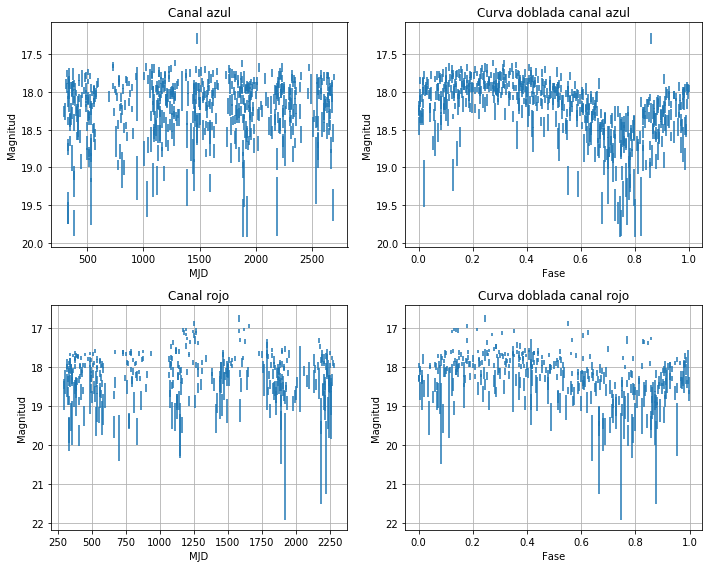

In [4]:
lc_index = 10
data = np.loadtxt(join(data_path, sub_class, lc_list[lc_index]+'.time'))
period = np.loadtxt(join(data_path, sub_class, lc_list[lc_index]+'.dat'))
mjd, mag_r, err_r, mag_b, err_b = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
"""
mjd_b = mjd
mjd_r = mjd
"""
mjd_b = mjd[err_b < 9.999]
mjd_r = mjd[err_r < 9.999]
mag_b = mag_b[err_b < 9.999]
mag_r = mag_r[err_r < 9.999]
err_b = err_b[err_b < 9.999]
err_r = err_r[err_r < 9.999]

mask = err_b < np.mean(err_b) + 3*np.std(err_b)
mjd_b = mjd_b[mask]
mag_b = mag_b[mask]
err_b = err_b[mask]
mask = err_r < np.mean(err_r) + 3*np.std(err_r)
mjd_r = mjd_r[mask]
mag_r = mag_r[mask]
err_r = err_r[mask]

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(2, 2, 1)
ax.errorbar(mjd_b, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitud')
plt.title('Canal azul')
plt.grid()

ax = fig.add_subplot(2, 2, 3)
ax.errorbar(mjd_r, mag_r, err_r, fmt='none')
ax.invert_yaxis()
plt.title('Canal rojo')
plt.xlabel('MJD')
plt.ylabel('Magnitud')
plt.grid()

ax = fig.add_subplot(2, 2, 2)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()

ax = fig.add_subplot(2, 2, 4)
ax.errorbar(np.mod(mjd_r, period)/period, mag_r, err_r, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal rojo')
plt.grid()
plt.tight_layout()


In [5]:
def smooth(x, window_len=11, window='hanning'):
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y    

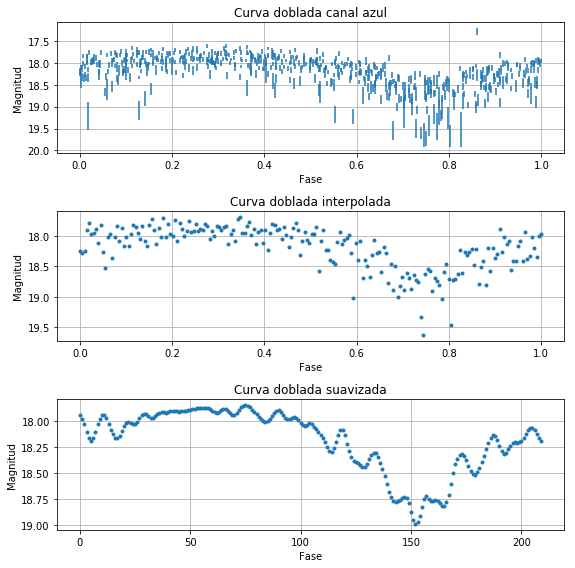

In [6]:
#np.interp()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(3, 1, 1)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()
plt.tight_layout()

phi = np.mod(mjd_b, period)/period
I = np.argsort(phi)
phi_rs = np.linspace(0, 1, num=200)
mag_b_rs = np.interp(phi_rs, phi[I], mag_b[I])

ax = fig.add_subplot(3, 1, 2)
ax.plot(phi_rs, mag_b_rs, '.')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada interpolada')
plt.grid()

ax = fig.add_subplot(3, 1, 3)
ax.plot(smooth(mag_b_rs, window_len=11, window='hanning'), '.')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada suavizada')
plt.grid()
plt.tight_layout()



In [7]:
import GPy

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPHeteroscedasticRegression(phi[:, np.newaxis], mag_b[:, np.newaxis], kernel)
m['.*het_Gauss.variance'] = err_b[:, np.newaxis]**2 
m.het_Gauss.variance.fix() 
#m.het_Gauss.period.fix() 
m.optimize()

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 5)
mu, var = m._raw_predict(phi_rs[:, np.newaxis])



Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s32  0004   1.619507e+03   1.725283e-09 
Runtime:     00s32
Optimization status: Converged

Optimization restart 1/5, f = 1619.5069949004787
Optimization restart 2/5, f = 1619.5069948911198
Optimization restart 3/5, f = 1632.0960449440413
Optimization restart 4/5, f = 1619.5069949931053
Optimization restart 5/5, f = 1619.5069950313339


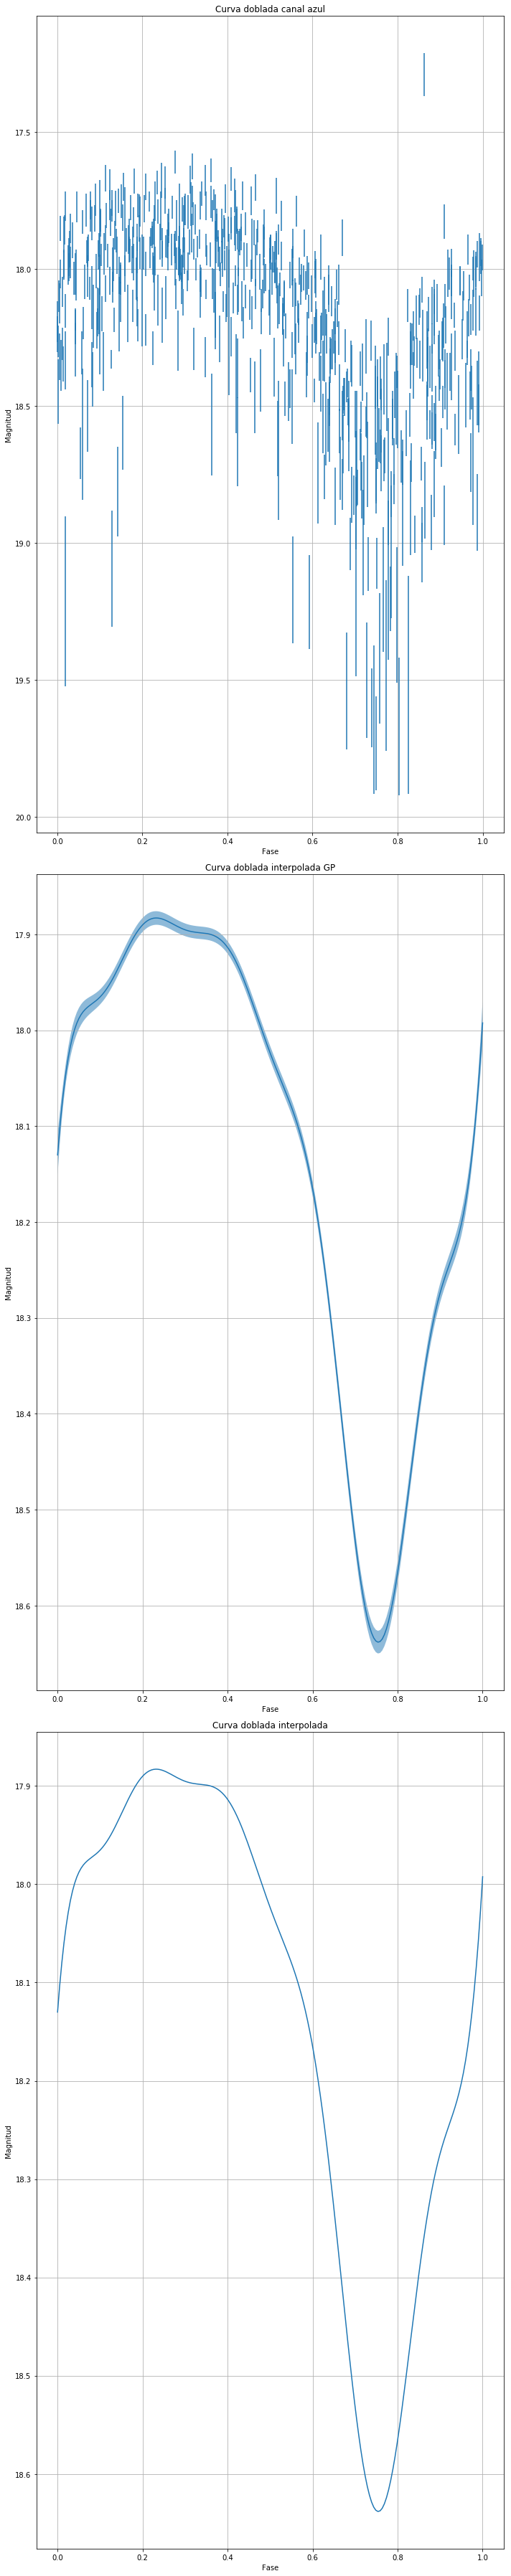

In [16]:
fig = plt.figure(figsize=(10, 50))

ax = fig.add_subplot(3, 1, 1)
ax.errorbar(np.mod(mjd_b, period)/period, mag_b, err_b, fmt='none')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada canal azul')
plt.grid()
plt.tight_layout()

ax = fig.add_subplot(3, 1, 3)
ax.plot(phi_rs, mu, '-')
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada interpolada')
plt.grid()

plt.tight_layout()


ax = fig.add_subplot(3, 1, 2)
ax.plot(phi_rs, mu, '-')
ax.fill_between(phi_rs, mu[:,0]-np.sqrt(var[:,0]), mu[:,0]+np.sqrt(var[:,0]), alpha=0.5)
ax.invert_yaxis()
plt.xlabel('Fase')
plt.ylabel('Magnitud')
plt.title('Curva doblada interpolada GP')
plt.grid()

plt.tight_layout()





In [11]:
print(phi_rs,mu[:,0])

[ 0.          0.00502513  0.01005025  0.01507538  0.0201005   0.02512563
  0.03015075  0.03517588  0.04020101  0.04522613  0.05025126  0.05527638
  0.06030151  0.06532663  0.07035176  0.07537688  0.08040201  0.08542714
  0.09045226  0.09547739  0.10050251  0.10552764  0.11055276  0.11557789
  0.12060302  0.12562814  0.13065327  0.13567839  0.14070352  0.14572864
  0.15075377  0.15577889  0.16080402  0.16582915  0.17085427  0.1758794
  0.18090452  0.18592965  0.19095477  0.1959799   0.20100503  0.20603015
  0.21105528  0.2160804   0.22110553  0.22613065  0.23115578  0.2361809
  0.24120603  0.24623116  0.25125628  0.25628141  0.26130653  0.26633166
  0.27135678  0.27638191  0.28140704  0.28643216  0.29145729  0.29648241
  0.30150754  0.30653266  0.31155779  0.31658291  0.32160804  0.32663317
  0.33165829  0.33668342  0.34170854  0.34673367  0.35175879  0.35678392
  0.36180905  0.36683417  0.3718593   0.37688442  0.38190955  0.38693467
  0.3919598   0.39698492  0.40201005  0.40703518  0.4